In [2]:
import numpy as np
import matplotlib.pyplot as plt

#Simulation data
width={} #nm
AxAy={} #nm**2
nlipids={} #Number of lipids per leaflet in that system
T="323" #Temperature was set to 323K in all systems, to have a fluid DPPC membrane.
for base in ["A","G","C","U","A2","C2","G2","U2"]:
    nlipids[base]=64
    width[base]=1.90905 
    AxAy[base]=6.83824*5.91206
for base in ["quadruplex","A3","U3","C3","G3"]:
    width[base]=3.857/2
    nlipids[base]=70
    AxAy[base]=7.154*6.204
            
width["strand"]=3.78/2
nlipids["strand"]=90
AxAy["strand"]=8.016*7.214

Na=6.022e23 #Avogadro number #mol**-1
ρwat_tip3p=0.997*1e-21 #1e-21 is the conversion from g/ml to g/nm**3
Mmol_wat=18.01 #Water molar density (g/mol)
Cwat=(ρwat_tip3p*Na)/Mmol_wat #Constant used in the calculation of partition coefficients.


def bin_map(cv,bins):
    """bin_map
        Maps the given cv into the given bins.
        In the sense that it returns the index of the corresponding bin for each value of the collective variable cv

        cv: collective variable to map
        bins: bins for the mapping
    """
    Δx=bins[1]-bins[0]
    cv_bins=np.zeros(len(cv))
    cv_sort=np.sort(cv)
    cv_sort_indices=np.argsort(cv)
    i_cv=0
    for i_bin,v_bin in enumerate(bins):
        stop=False
        while i_cv < len(cv) and stop==False:
            if cv_sort[i_cv] >= v_bin and cv_sort[i_cv] <= v_bin + Δx:
                cv_bins[cv_sort_indices[i_cv]]=i_bin
                i_cv+=1
            else:
                stop=True
    return cv_bins


def two_indep_simulations(cv,d_z,bias,Nbins,d,nucl,nblocks=5,iter_numb=200):
    """two_indep_simulations
        Runs analyses separately for the two sides of the membrane and computes averages/errors exploting these two "independent" simulations + bayesian bootstrap estimated separately for each of them
        cv: collective variable for which to run the analysis
        d_z: value of d_z so that you have information on which side of the membrane you are on
        bias: value of the bias at each frame
        Nbins: number of bins for free energy estimation
        d: array [d1,d2,d3,d4] for the different thresholds to use
        nucl: system name, for the calculation of partition coefficients
        nblocks: number of blocks for bayesian bootstrap
        iter_numb: number of iterations for bayesian bootstrap
    """
    Nw=Cwat*AxAy[nucl]*(d[3]-d[2]) #Approximate number of water molecules which are found in the volume partition defined by the given threshold
    Nl=nlipids[nucl] #Number of lipids in the bound state (necessarily the total number of lipids in the simulation).
    kBT=2.478*323/298 #kJ/mol

    xmin=np.min(cv) #Same minimum and same maximum for both sides, that is why they are computed beforehand
    xmax=np.max(cv) 
    bins=np.linspace(xmin,xmax,int(Nbins)+1)
    #Iterate on the two possible sides of the membrane.
    bias=bias-np.max(bias)
    z=(bins[:-1]+bins[1:])/2

    logks=np.zeros(2)
    err_logks=np.zeros(2)
    zmins=np.zeros(2)
    err_zmins=np.zeros(2)
    fes=np.zeros((2,len(bins)-1))
    err_fes=np.zeros((2,len(bins)-1))
    for i_sign,sign in enumerate([1,-1]):  #Iterate on the two possible sides of the membrane.
        sel=d_z*sign>0
        cv_sel=cv[sel]
        cv_bins=bin_map(cv_sel,bins)
        bias_sel=bias[sel]
        #Given this, you perform bayesian bootstrap on top of the selected trajectory chunk.
        output=b_bootstrap(cv_sel,bias_sel,len(cv_sel)//nblocks,bins,d,cv_bins,nucl,iter_numb=iter_numb)
        fes[i_sign,:]=output["fes"]
        err_fes[i_sign,:]=output["err_fes"]
        logks[i_sign]=output["logk"]
        err_logks[i_sign]=output["err_logk"]
        zmins[i_sign]=output["zmin"]
        err_zmins[i_sign]=output["err_zmin"]
    avg_logk=np.average(logks)
    err_logk=np.sqrt(0.5*(np.std(logks)**2+(np.std(err_logks)**2))) #This combines the error deriving from differences in the logk values in the two simulation + their statistical errors.
    
    zmin=np.average(zmins)
    err_zmin=np.sqrt(0.5*(np.std(zmins)**2+(np.std(err_zmins))**2))
    
    avg_fes=np.average(fes,axis=0)  
    err_fes=np.sqrt(0.5*(np.std(fes,axis=0)**2+(np.std(err_fes,axis=0)**2)))

    out={}
    out["fes"]=avg_fes       
    out["err_fes"]=err_fes              
    out["logk"]=avg_logk
    out["err_logk"]=err_logk
    out["z"]=output["z"]
    out["zmin"]=zmin
    out["err_zmin"]=err_zmin
    return out

def b_bootstrap(cv,bias,blocksize,bins,d,cv_bins,nucl,iter_numb=200):
    """b_bootstrap
    It performs Bayesian Bootstrap of certain quantities, computing averages and errors,
    for logPs and free energy profiles.
    cv: cv for which to do bootstrapping
    bias: value of the bias for each frame
    blocksize: size of the blocks for the bootstrap
    bins: bins for the free energy profile
    d: array [d1,d2,d3,d4] for the different thresholds to use
    cv_bins: bins for the mapping of the cv
    nucl: system name, for the calculation of partition coefficients
    iter_numb: number of iterations for bayesian bootstrap
    """
    kBT=2.478*323/298
    Nw=Cwat*AxAy[nucl]*(d[3]-d[2]) 
    Nl=nlipids[nucl]
    Nbins=len(bins)-1
    nblocks = len(cv) // blocksize
    remainder = len(cv) % blocksize
    block_ids=np.arange(0,nblocks,1)
    bias=bias-np.max(bias)
    z=(bins[:-1]+bins[1:])/2
    xmin=np.min(bins)
    xmax=np.max(bins)
    

    if remainder>0:#exclude the remainder from the analysis (it would be very few frames anyways)
        cv = cv[:-remainder]
        bias = bias[:-remainder]
    L= len(cv)
    w=np.exp(bias/kBT) #w : weight for the single frame
    cv=np.reshape(cv,(nblocks,blocksize)) #reshapes the CV in order to have a matrix with nblocks rows and blocksize columns
    w=np.reshape(w,(nblocks,blocksize))
    funcz_lip=(np.abs(cv)<d[1])*(np.abs(cv)>d[0]) #This is f_i^L defined in the paper, 1 when RNA bound, 0 when unbound
    funcz_wat=(np.abs(cv)<d[3])*(np.abs(cv)>d[2]) #f_i^W: 1 when bound to water, 0 when unbound.
    obs_lip=w*funcz_lip
    obs_wat=w*funcz_wat

    w_bootstrap=np.zeros((nblocks,iter_numb))
    for r in range(iter_numb):
        block_selected=np.random.choice(block_ids,replace=True,size=len(block_ids))
        #w_bootstrap[:,r] = np.bincount(block_selected, minlength=nblocks) #this is just bootstrap
        w_bootstrap[:,r]=len(block_ids)*np.random.dirichlet(alpha=1*np.ones(len(block_ids))) #Extracts weights for each block from a Dirichlet distribution ,in order to peform Bayesian Bootstrap.
    w_normaltraj=np.ones(len(block_ids)) #Weights of blocks asocialted to the full trajectory, to compute the average.
    fl_ntraj=np.sum(w_normaltraj.T@obs_lip) #This is the numerator sum in the ratio to compute logP.
    fw_ntraj=np.sum(w_normaltraj.T@obs_wat) #Denominator, same as above
    logk_ntraj=np.log10((Nw/Nl)*fl_ntraj/fw_ntraj) #Estimation of logP for the full trajectory.
    
    fl_r=np.sum(w_bootstrap.T@obs_lip,axis=1) #For each iteration of bayesian bootstrap you have a vector fl_r which contains the numerator sum to compute logP.and
    fw_r=np.sum(w_bootstrap.T@obs_wat,axis=1) #Same as above.
    #You then have iter_numb values of fl_r and fl_w, so that yo ucan compute logk n_iter times.
    logk=np.log10((Nw/Nl)*fl_r/fw_r) #vector of logP values for each iteration of bayesian bootstrap.

    fes=np.zeros((iter_numb,Nbins))
    zmins=np.zeros(iter_numb)
    wflat=w.flatten()
    for r in range(iter_numb):
        bias_r=np.repeat(w_bootstrap[:,r],L/nblocks)*wflat #Finds the bias associated to each frame, using both the weights coming from bayesian bootstrap + weight coming from wtMetaD
        a,b=np.histogram(cv.flatten(), weights=bias_r,bins=Nbins,range=(xmin,xmax))
        fes[r]=-kBT*np.log(a)
        zmins[r]=z[np.argmin(fes[r])] #Estimates the position of the minimum in the free energy profile.
    a,b=np.histogram(cv.flatten(), weights=w.flatten(),bins=Nbins,range=(xmin,xmax))#the avg fes is for the full trajectory
    
    avg_fes=-kBT*np.log(a)
    err_fes=np.std(fes,axis=0)
    zmin=z[np.argmin(avg_fes)]
    err_zmin=np.std(zmins)
    avg_logk=logk_ntraj
    err_logk=np.std(logk,axis=0)
    avg_fes=np.average(fes,axis=0)
    out={}
    out["fes"]=avg_fes          
    out["err_fes"]=err_fes    
    out["zmin"]=zmin
    out["err_zmin"]=err_zmin
    out["logk"]=avg_logk
    out["err_logk"]=err_logk
    out["logks"]=logk
    out["z"]=z
    return out

def compute_avgs(cv,zdist,weights,nblocks=5):
    """compute_avgs
        Used to compute averages and errors of cv, given the weights and corresponding d_z at each timeframe. This allows to have two components of the error:
            1. related to difference between the membrane sides
            2. sum of two statistical errors coming from Bayesian Bootstrap
    cv: cv at each frame
    zdist: d_z of each frame
    weights: weight of each frame
    nblocks: number of blocks
    """

    err=np.zeros(2)
    obs=np.zeros(2)
    cv=np.asarray(cv)
    for i_sign,sign in enumerate([1,-1]):
        sel=zdist*sign>0
        cv_sel=cv[sel]
        weights_sel=weights[sel]
        obs[i_sign]=np.average(cv_sel,weights=weights_sel)
        err[i_sign]=b_bootstrap_scalar(cv_sel,len(cv_sel)//nblocks,weights_sel)[1]
    err_syst=np.std(obs)
    err_stat=np.std(err)
    error=(1/np.sqrt(2))*np.sqrt(err_syst**2+err_stat**2)
    avg=np.average(obs)
    return avg,error
def b_bootstrap_scalar(cv,blocksize,weights,iter_numb=200):
    """b_bootstrap_scalar
        Performs bayesian bootstrap, to compute error of cv.

    cv: collective variable at each frame
    blocksize: size of the block
    weights: weight of each frame
    iter_numb: number of bootstrap iterations
    """
    nblocks = len(cv) // blocksize
    remainder = len(cv) % blocksize
    block_ids=np.arange(0,nblocks,1)

    if remainder>0:
        cv = cv[:-remainder]
        weights = weights[:-remainder]
    L= len(cv)
    cv=np.reshape(cv,(nblocks,blocksize))
    w=np.reshape(weights,(nblocks,blocksize))
    w_bootstrap=np.zeros((nblocks,iter_numb))
    avg=np.zeros(iter_numb)
    wflat=w.flatten()
    for r in range(iter_numb):
        block_selected=np.random.choice(block_ids,replace=True,size=len(block_ids))
        #w_bootstrap[:,r] = np.bincount(block_selected, minlength=nblocks) #this is just bootstrap
        w_bootstrap[:,r]=len(block_ids)*np.random.dirichlet(alpha=1*np.ones(len(block_ids)))
    for r in range(iter_numb):
        bias_r=np.repeat(w_bootstrap[:,r],L/nblocks)*wflat
        avg[r]=np.average(cv.flatten(),weights=bias_r)
    err=np.std(avg,axis=0)
    return np.average(np.ndarray.flatten(cv),weights=np.ndarray.flatten(weights)),err

## Nucleosides and polynucleotides

C:\Users\salvo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


G2  zmin:  1.7876543333333335 ± 0.049405672962557344  Angstrom
A2  zmin:  1.590915 ± 0.02544329037342175  Angstrom
U2  zmin:  1.654808 ± 0.047619594805770826  Angstrom
C2  zmin:  1.7928422666666668 ± 0.05524905158791588  Angstrom


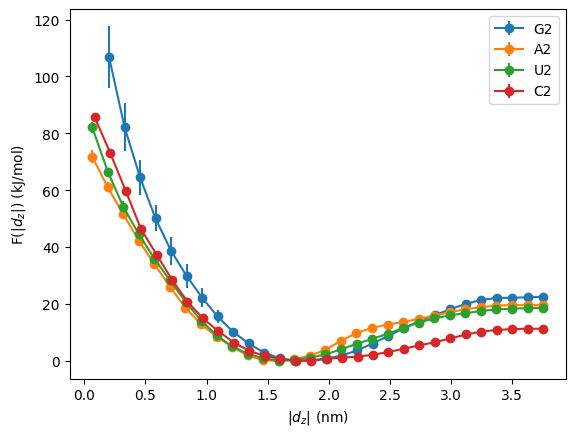

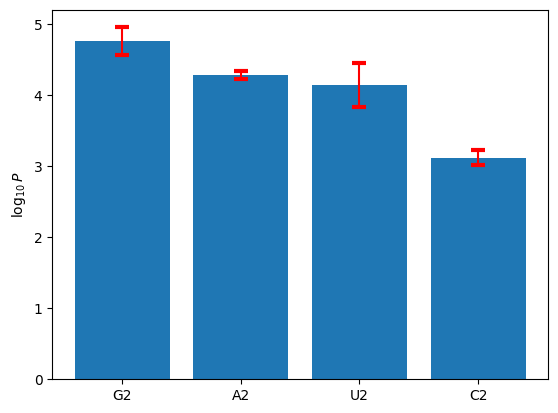

In [2]:
np.seterr(divide = 'ignore') #warnings related to log(0) are suppressed
nucls=["G2","A2","U2","C2"]
Nbins=30
logks=[]
err_logks=[]
namelist=[]
for nucl in nucls:
    data=np.loadtxt("../outputs/metad/METADYN_VMAX_"+nucl)
    cv=data[:,2]
    bias=data[:,3]
    d1=0
    d2=np.max(np.abs(cv))*0.85
    d3=np.max(np.abs(cv))*0.85
    d4=np.max(np.abs(data[:,1]))*0.95
    d=[d1,d2,d3,d4]
    output=two_indep_simulations(np.abs(cv),cv,bias,Nbins,d,nucl)
    plt.errorbar(output["z"],output["fes"]-np.min(output["fes"]),yerr=output["err_fes"],label=nucl,marker='o')
    print(nucl," zmin: ", output["zmin"],"±",output["err_zmin"]," Angstrom")
    logk=output["logk"]
    logks.append(logk)
    err_logks.append(output["err_logk"])
    namelist.append(nucl)
plt.xlabel(r"$|d_z|$ (nm)")
plt.ylabel(r"F($|d_z|$) (kJ/mol)")
plt.legend()
plt.show()
plt.bar(namelist,logks)
plt.errorbar(namelist,logks,yerr=err_logks,marker='o',barsabove=True,capsize=5,capthick=3,fmt='none',ecolor='red')
plt.ylabel(r"$\log_{10}P$")
plt.show()

## G-Quadruplex

Quadruplex:   zmin:  2.7735849 ± 0.10442781640539699  Angstrom
Quadruplex:  7.984953352940192 ± 0.476891521036185


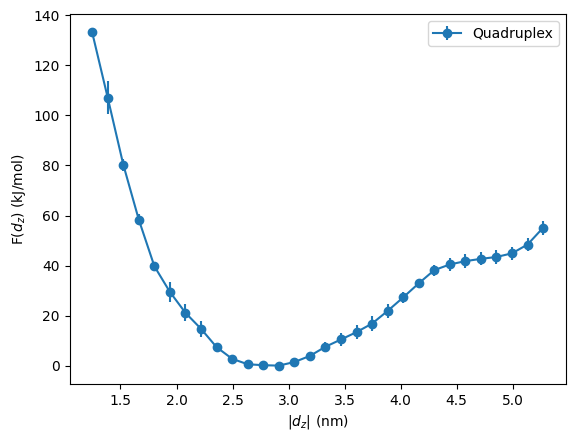

In [3]:
data=np.loadtxt("../outputs/metad/METADYN_VMAX_quadruplex")
nucl="quadruplex"
cv=data[:,2]
Nbins=30
bias=data[:,4]+data[:,5]
d1=0
d2=4
d3=4.6
d4=4.8
d=[d1,d2,d3,d4]
output=two_indep_simulations(np.abs(cv),cv,bias,Nbins,d,nucl)
plt.errorbar(output["z"],output["fes"]-np.min(output["fes"]),yerr=output["err_fes"],label="Quadruplex",marker='o')
print("Quadruplex: "," zmin: ", output["zmin"],"±",output["err_zmin"]," Angstrom")
logk=output["logk"]
plt.xlabel(r"$|d_z|$ (nm)")
plt.ylabel(r"F($d_z$) (kJ/mol)")
plt.legend()
print("Quadruplex: ",logk,"±",output["err_logk"])

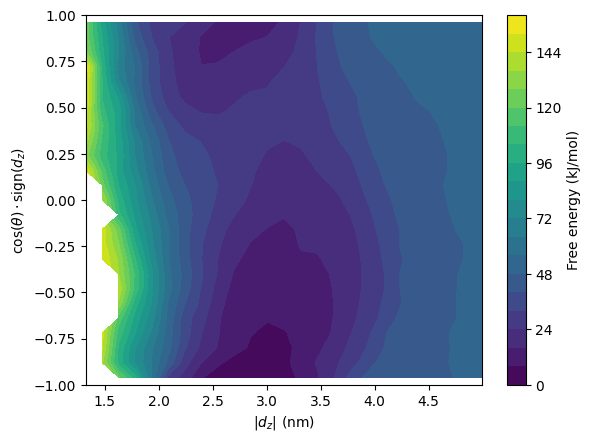

In [4]:

data=np.loadtxt("../outputs/metad/METADYN_VMAX_quadruplex")
kBT=2.478*323/298
bias=data[:,4]+data[:,5]
cosθ=data[:,3]
zdist=data[:,2]
max_z=np.max(np.abs(data[:,1]))
min_z=np.min(np.abs(data[:,1]))
weights=np.exp((bias-np.max(bias))/kBT)
a1=np.histogram2d(cosθ[zdist>0],np.abs(zdist)[zdist>0],bins=25,weights=weights[zdist>0],density=True,range=[[-1,1], [min_z, max_z]])
a2=np.histogram2d(-cosθ[zdist<0],np.abs(zdist)[zdist<0],bins=25,weights=weights[zdist<0],density=True,range=[[-1,1], [min_z,max_z]])

X=(a1[2][:-1]+a1[2][1:])/2
Y=(a1[1][:-1]+a1[1][1:])/2
Z1=-kBT*np.log(a1[0])
Z2=-kBT*np.log(a2[0])
Z1_masked = np.ma.masked_invalid(Z1)
Z2_masked = np.ma.masked_invalid(Z2)
Z_average = (Z1_masked + Z2_masked) / 2
savedata=np.zeros((len(X),2))  
savedata[:,0]=X
savedata[:,1]=Y
Z=Z_average-np.min(Z_average)
CS=plt.contourf(X, Y, Z, 25, cmap=plt.cm.viridis)
cbar = plt.colorbar(CS)
cbar.set_label('Free energy (kJ/mol)')  
plt.xlabel(r"$|d_z|$ (nm)")
plt.ylabel(r"$\cos(\theta)\cdot \text{sign}(d_z)$")
plt.ylim(top=1,bottom=-1)
minpos=np.unravel_index(Z_average.argmin(), Z_average.shape)
plt.show()

plt.show()

## 19-mer ssRNA

Strand:   zmin:  1.3401234999999998 ± 0.08532885173671534  Angstrom
Strand:  17.122761559507286 ± 0.28215045744665285


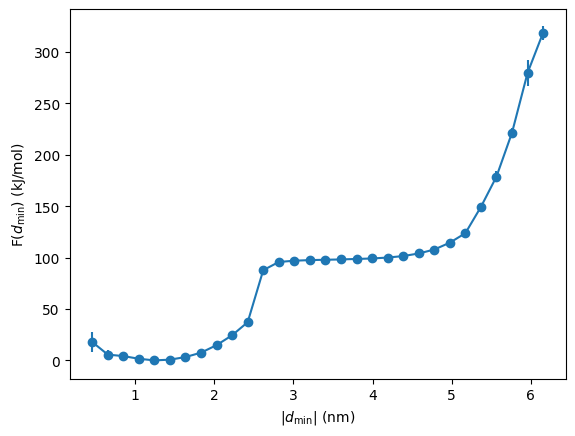

In [7]:
data=np.loadtxt("../outputs/metad/METADYN_VMAX_strand")
nucl="strand"
cv=data[:,1]
d_z=data[:,3]
bias=data[:,4]
d1=0
d2=3
d3=3.25
d4=4
d=[d1,d2,d3,d4]
output=two_indep_simulations(cv,d_z,bias,Nbins,d,nucl)
plt.errorbar(output["z"],output["fes"]-np.min(output["fes"]),yerr=output["err_fes"],label="Quadruplex",marker='o')
print("Strand: "," zmin: ", output["zmin"],"±",output["err_zmin"]," Angstrom")
logk=output["logk"]


plt.xlabel(r"$|d_{\text{min}}|$ (nm)")
plt.ylabel(r"F($d_{\text{min}}$) (kJ/mol)")
print("Strand: ",logk,"±",output["err_logk"])

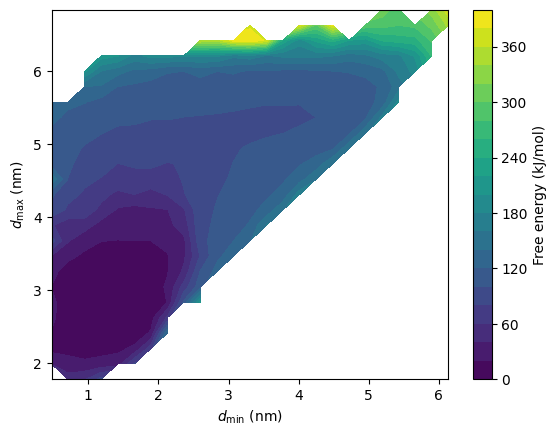

In [8]:


data=np.loadtxt("../outputs/metad/METADYN_VMAX_strand")
bias=data[:,4]
mindist=data[:,1]
maxdist=data[:,2]
zdist=data[:,3]
weights=np.exp((bias-np.max(bias))/kBT)


minmax=np.min(maxdist)
maxmax=np.max(maxdist)
minmin=np.min(mindist)
maxmin=np.max(mindist)
weights=np.exp((bias-np.max(bias))/kBT)
a1=np.histogram2d(maxdist[zdist>0],mindist[zdist>0],bins=25,weights=weights[zdist>0],density=True,range=[[minmax,maxmax], [minmin, maxmin]])
a2=np.histogram2d(maxdist[zdist<0],mindist[zdist<0],bins=25,weights=weights[zdist<0],density=True,range=[[minmax,maxmax], [minmin, maxmin]])

X=(a1[2][:-1]+a1[2][1:])/2
Y=(a1[1][:-1]+a1[1][1:])/2
Z1=-kBT*np.log(a1[0])
Z2=-kBT*np.log(a2[0])
Z1_masked = np.ma.masked_invalid(Z1)
Z2_masked = np.ma.masked_invalid(Z2)
Z_average = (Z1_masked + Z2_masked) / 2
Z=Z_average-np.min(Z_average)
CS=plt.contourf(X, Y, Z, 25, cmap=plt.cm.viridis)
cbar = plt.colorbar(CS)
cbar.set_label('Free energy (kJ/mol)')  
plt.xlabel(r"$d_{\text{min}}$ (nm)")
plt.ylabel(r"$d_{\text{max}}$ (nm)")
minpos=np.unravel_index(Z.argmin(), Z.shape)
Z[Z<2.5*kBT]
#print(X[minpos[1]],Y[minpos[0]])
plt.show()
plt.show()

## Orientation analysis for nucleosides

C:\Users\salvo\AppData\Local\Temp\ipykernel_15068\3327945392.py:147: RuntimeWarning: invalid value encountered in scalar divide
  logk_ntraj=np.log10((Nw/Nl)*fl_ntraj/fw_ntraj) #Estimation of logP for the full trajectory.
C:\Users\salvo\AppData\Local\Temp\ipykernel_15068\3327945392.py:152: RuntimeWarning: invalid value encountered in divide
  logk=np.log10((Nw/Nl)*fl_r/fw_r) #vector of logP values for each iteration of bayesian bootstrap.


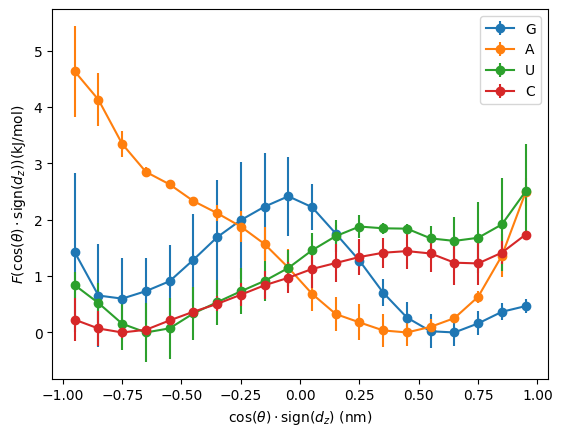

In [9]:
np.seterr(divide = 'ignore') #warnings related to log(0) are suppressed
nucls=["G","A","U","C"]
Nbins=20
logks=[]
err_logks=[]
namelist=[]
for nucl in nucls:
    data=np.loadtxt("../outputs/orientation/ANALYSIS_NORMAL_"+nucl)
    data_MD=np.loadtxt("../outputs/metad/METADYN_VMAX_"+nucl)
    zdist=data_MD[:,1]
    cv=data[:,1]*np.sign(zdist)
    bias=data_MD[:,3]
    d=np.zeros(4) #d is defined here but all the logP part is not used in this analysis (output is completely meaningless, I just didn't want to change the function)
    output=two_indep_simulations(cv,zdist,bias,Nbins,d,nucl)
    plt.errorbar(output["z"],output["fes"]-np.min(output["fes"]),yerr=output["err_fes"],label=nucl,marker='o')

plt.xlabel(r"$\cos (\theta)\cdot \text{sign}(d_z)$ (nm)")
plt.ylabel(r"$F(\cos (\theta)\cdot \text{sign}(d_z)) $(kJ/mol)")
plt.legend()
plt.show()

## Orientation analysis for dinucleotides

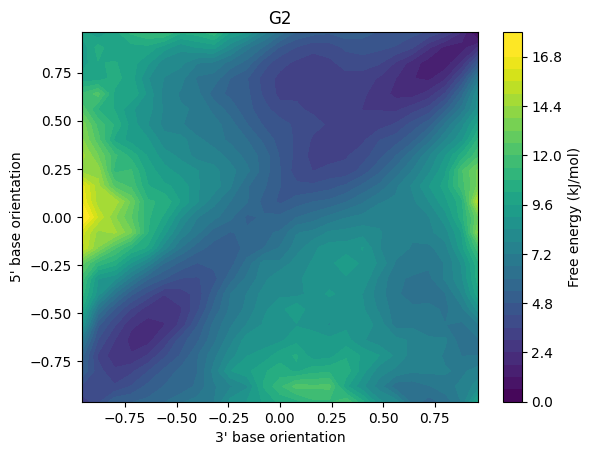

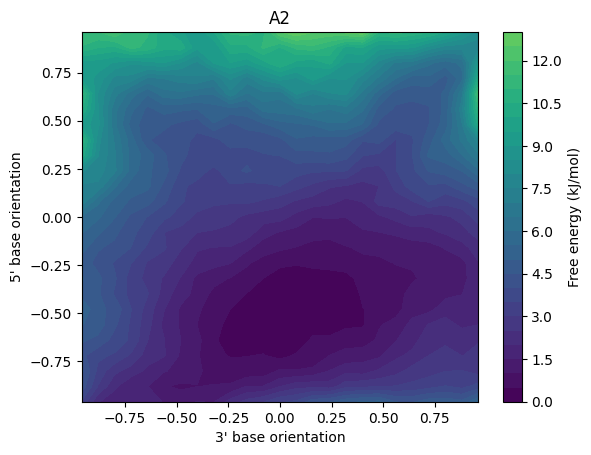

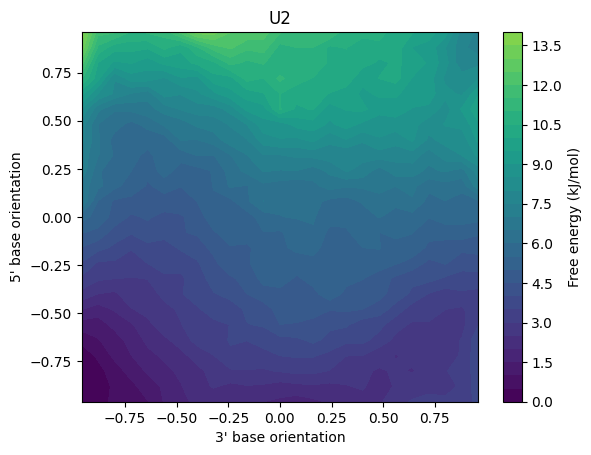

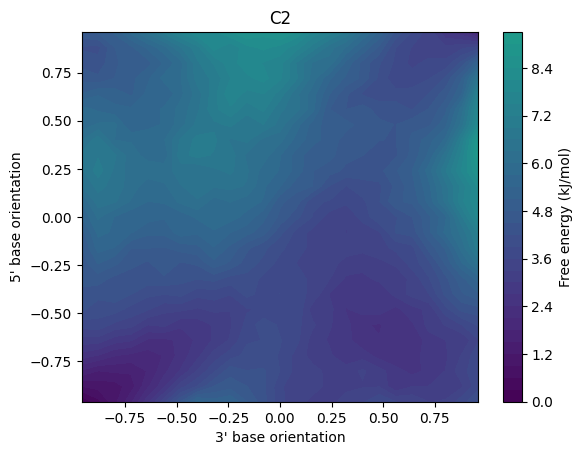

In [6]:

T=323

plt.show()
nucls=["G2","A2","U2","C2"]
for nucl in nucls:

    data_MD=np.loadtxt("../outputs/metad/METADYN_VMAX_"+nucl)
    data_normal=np.loadtxt("../outputs/orientation/ANALYSIS_NORMAL_"+nucl)
    kBT=(2.47/298)*T
    zdist=data_MD[:,1]
    selected=np.abs(zdist)<10 #select all states (no real difference, the bias is governing the state selection)
    bias=data_MD[selected,3]-np.max(data_MD[selected,3])
    weights=np.exp(bias/kBT)

    cv=np.abs(zdist)
    

    normal1=data_normal[selected,1]*np.sign(zdist[selected])
    normal2=data_normal[selected,2]*np.sign(zdist[selected])
    zdist=zdist[selected]
    a1=np.histogram2d(normal1[zdist>0],normal2[zdist>0],bins=25,weights=weights[zdist>0],range=[[-1,1],[-1,1]],density=True)
    a2=np.histogram2d(normal1[zdist<0],normal2[zdist<0],bins=25,weights=weights[zdist<0],range=[[-1,1],[-1,1]],density=True) 
    X=(a1[2][:-1]+a1[2][1:])/2
    Y=(a1[1][:-1]+a1[1][1:])/2
    Z1=-kBT*np.log(a1[0])
    Z2=-kBT*np.log(a2[0])
    Z1_masked = np.ma.masked_invalid(Z1)
    Z2_masked = np.ma.masked_invalid(Z2)
    Z_average = (Z1_masked + Z2_masked) / 2

    Z=Z_average-np.min(Z_average)
    CS=plt.contourf(X, Y, (Z_average-np.min(Z_average)), 30,vmax=17)
    minpos=np.unravel_index(Z_average.argmin(), Z_average.shape)
    cbar = plt.colorbar(CS)
    cbar.set_label('Free energy (kJ/mol)')
    plt.xlabel("3' base orientation")
    plt.ylabel("5' base orientation")
    plt.title(nucl)
    plt.show()


## Puckering analysis for the loops of the G-quadruplex

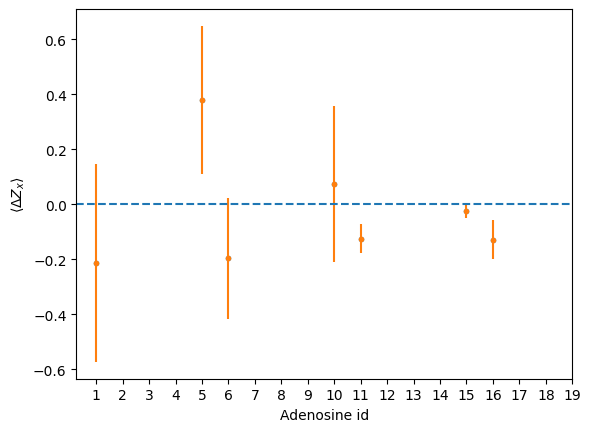

In [25]:
stride=25 #stride which was used to look at the number of contacts made by each sugar in the quadruplex
puckers=np.loadtxt("../outputs/orientation/ANALYSIS_PUCKERING_quadruplex")[::stride,1:]
kBT=2.47*323/293
adeno_ids=[0,4,5,9,10,14,15] # indices associated to adenosines in the G-quadruplex
guano_ids=[1,2,3,6,7,8,11,12,13]
data_quad=np.loadtxt("../outputs/metad/METADYN_VMAX_quadruplex")[::stride,:]
bias=data_quad[:,4]+data_quad[:,5]
zdist=data_quad[:,2]
ori=data_quad[:,3]
contacts_residue=np.loadtxt("../outputs/contacts/sugarcontacts_quadruplex.dat")

bias=bias-np.max(bias)
weights=np.exp(bias/kBT)

avgs_bound=np.zeros(len(adeno_ids))
errs_bound=np.zeros(len(adeno_ids))
avgs_unbound=np.zeros(len(adeno_ids))
errs_unbound=np.zeros(len(adeno_ids))
for i_adeno_id,i in enumerate(adeno_ids):
    #selection of bound/unbound states for each of the adenosine sugars
    bound=contacts_residue[:,i]>0
    unbound=contacts_residue[:,i]==0
    avgs_bound[i_adeno_id],errs_bound[i_adeno_id]=compute_avgs(puckers[bound,i],zdist[bound],weights[bound])
    avgs_unbound[i_adeno_id],errs_unbound[i_adeno_id]=compute_avgs(puckers[unbound,i],zdist[unbound],weights[unbound])
plt.plot(np.array(adeno_ids)+1,avgs_bound-avgs_unbound,'.')
plt.errorbar(np.array(adeno_ids)+1,avgs_bound-avgs_unbound,yerr=np.sqrt(errs_bound**2+errs_unbound**2),fmt='.')
plt.xlabel("Adenosine id")
plt.ylabel(r"$\langle \Delta Z_x\rangle$")
plt.axhline(0,linestyle='dashed')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
plt.show()

#The same analyses can be performed for guanine sugars, and the differences are even less significant.